In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.feature_selection import RFECV

from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score, classification_report, fbeta_score, plot_confusion_matrix, make_scorer

fbeta = make_scorer(fbeta_score, beta=0.4)

##### *ACLARACION: Para las metricas optamos primero por utilizar auc, para elegir el mejor clasificador, debido a que las clases no estan demasiado desbalanceadas, y luego utilizaremos fbeta_score, con un beta de 0.4, que valore mas la precision, ya que nosotros queremos priorizar recomendar canciones que realmente le vayan a gustar a nuestro usuario, asumiendo que aumentaremos la cantidad de canciones que podrian gustarle, pero no le recomendaremos (False Negative)*

In [2]:
music = pd.read_csv("training_data.csv")

data = music.copy()
data.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
0,0.713,0.514,100125,0.521,0.816000,8,0.1120,-14.835,0,0.0444,119.879,4,0.143,1
1,0.192,0.714,207019,0.614,0.000000,4,0.2630,-6.935,1,0.0319,123.969,4,0.582,1
2,0.333,0.630,216200,0.455,0.000004,5,0.1270,-9.290,1,0.0292,139.931,4,0.199,1
3,0.601,0.810,136413,0.221,0.210000,5,0.1840,-11.005,1,0.0429,109.960,4,0.798,1
4,0.883,0.465,181440,0.459,0.000173,6,0.0692,-8.137,0,0.0351,90.807,4,0.288,1


## EXPLORATORY DATA ANALYSIS (EDA)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      750 non-null    float64
 1   danceability      750 non-null    float64
 2   duration          750 non-null    int64  
 3   energy            750 non-null    float64
 4   instrumentalness  750 non-null    float64
 5   key               750 non-null    int64  
 6   liveness          750 non-null    float64
 7   loudness          750 non-null    float64
 8   mode              750 non-null    int64  
 9   speechiness       750 non-null    float64
 10  tempo             750 non-null    float64
 11  time_signature    750 non-null    int64  
 12  valence           750 non-null    float64
 13  label             750 non-null    int64  
dtypes: float64(9), int64(5)
memory usage: 82.2 KB


Observamos que todas nuestras features son numericas

In [4]:
data.isna().all() # No hay registros incompletos

acousticness        False
danceability        False
duration            False
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo               False
time_signature      False
valence             False
label               False
dtype: bool

In [5]:
data.describe()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,label
count,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,0.357394,0.596439,220112.733333,0.594188,0.100245,4.829333,0.203376,-8.509339,0.741333,0.098966,120.405761,3.902667,0.497321,0.602667
std,0.338405,0.172036,65587.690483,0.253301,0.259921,3.636001,0.177609,5.039488,0.438194,0.104715,28.378116,0.400091,0.239615,0.489673
min,0.000001,0.107000,33840.000000,0.009250,0.000000,0.000000,0.024000,-29.601000,0.000000,0.023400,55.747000,1.000000,0.033200,0.000000
25%,0.037150,0.480000,185490.250000,0.423250,0.000000,1.000000,0.094550,-10.173500,0.000000,0.035900,98.998000,4.000000,0.297000,0.000000
50%,0.244500,0.606000,215108.500000,0.631500,0.000010,5.000000,0.129000,-7.270000,1.000000,0.048750,120.104500,4.000000,0.483000,1.000000
75%,0.678500,0.715750,244236.750000,0.804750,0.002245,8.000000,0.264750,-5.097750,1.000000,0.113000,138.074750,4.000000,0.684500,1.000000
max,0.994000,0.986000,675360.000000,0.995000,0.967000,11.000000,0.979000,-0.533000,1.000000,0.721000,204.162000,5.000000,0.975000,1.000000


In [6]:
# Observamos un pequeño desbalance para la clase positiva (le gusta la cancion) en este dataset
data.label.value_counts(normalize = True)*100

1    60.266667
0    39.733333
Name: label, dtype: float64

Parece haber una correlacion lineal de casi el 50% con varias features, por ejemplo acousticness, speechinees, energy and loudness.

In [7]:
# Observamos si hay correlaciones altas(mayor al 40%) entre los regresores

data.drop("label", axis = 1).corr()[abs(data.corr())>0.4]

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
acousticness,1.000000,-0.417974,NaN,-0.781691,NaN,NaN,NaN,-0.695163,NaN,NaN,NaN,NaN,NaN
danceability,-0.417974,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.483361
duration,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy,-0.781691,NaN,NaN,1.000000,NaN,NaN,NaN,0.830081,NaN,NaN,NaN,NaN,NaN
instrumentalness,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,-0.429529,NaN,NaN,NaN,NaN,NaN
key,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
liveness,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
loudness,-0.695163,NaN,NaN,0.830081,-0.429529,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
mode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
speechiness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


Observamos que varias features se encuentran correlacionadas, las que poseen mayores problemas de multicolinealidad son `acousticness`, `danceability`, `energy` y `loudness`.

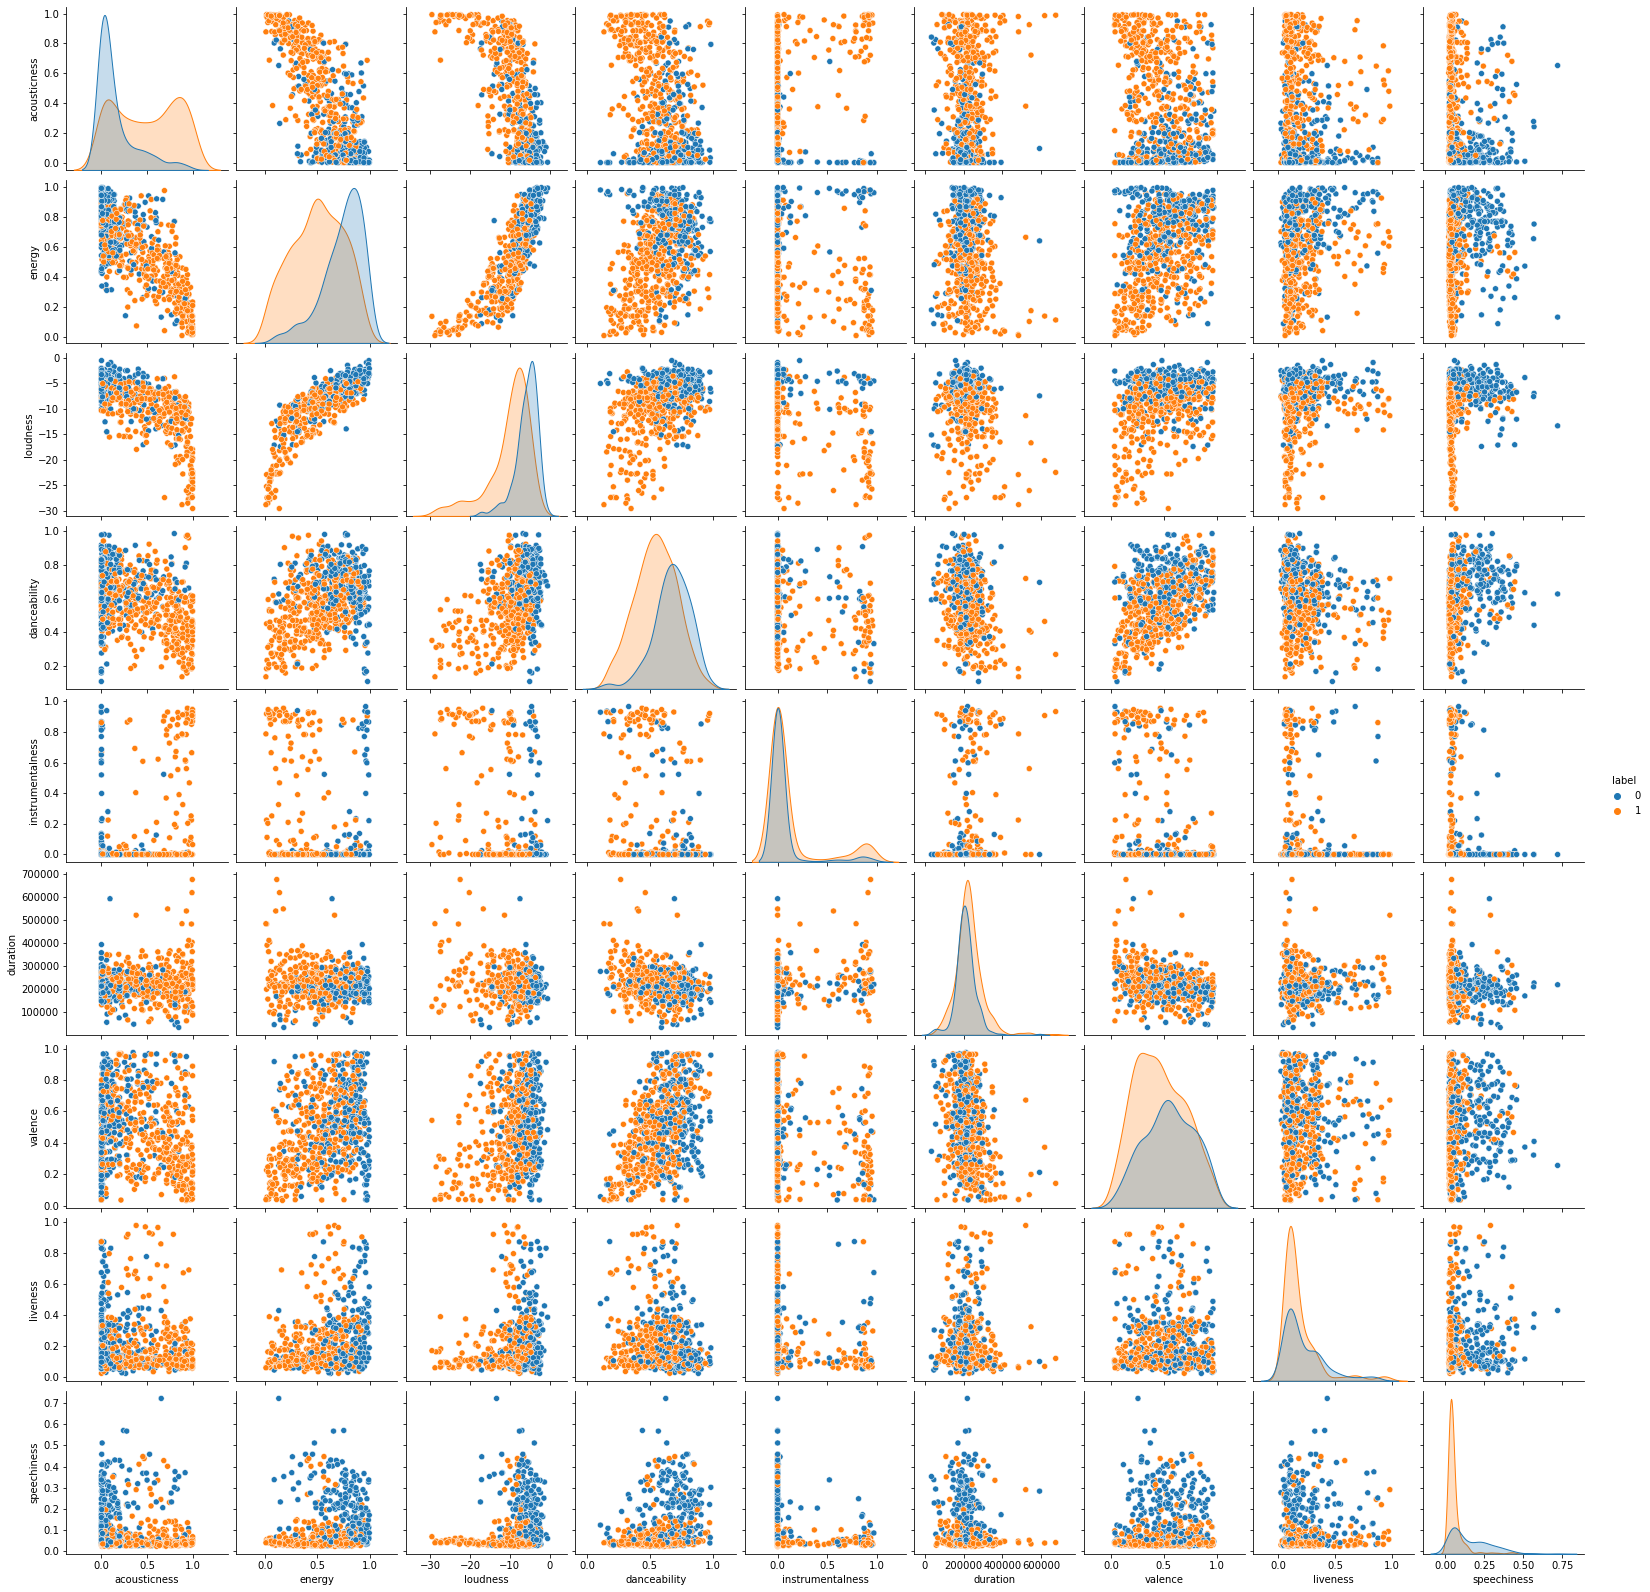

In [8]:
cols = ["acousticness", "energy", "loudness", "danceability", "instrumentalness", "duration", "valence", "liveness", "speechiness", "label"]
sns.pairplot(data.loc[:, cols], hue = 'label')
plt.show()

Observamos que varias features presentan una distribucion que se asemeja a una gausseana. 

## MODELADO

In [9]:
X = data.drop('label', axis = 1)
y = data.label
random_state = 1203

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = random_state)

#### MODELO BASELINE

In [10]:
dc = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

accuracy_score(y_test, dc.predict(X_test))

0.601063829787234

Observamos que nuestro modelo base de clasificacion tiene un piso del 60%.

#### REGRESION LOGISTICA

In [11]:
pipe_regresion_logistica = Pipeline(steps = [("estandarizacion", StandardScaler()),
                                             ("clasificador", LogisticRegression())])

param_grid_lr = {
    "clasificador__C":[0.001, 0.01, 0.1, 1],
    "clasificador__penalty":["l1","l2"],
    "clasificador__solver":["liblinear"]
}

grid_search_lr = GridSearchCV(estimator = pipe_regresion_logistica,   
                                param_grid= param_grid_lr, 
                                scoring= fbeta, 
                                cv = 5)
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_

print("Validation set F_beta score: ",grid_search_lr.best_score_) 

Validation set F_beta score:  0.8546394486546947


### METRICA REGRESION LOGISTICA

In [12]:
fbeta_score(y_test, best_lr.predict(X_test), beta=0.4)

0.840439706862092

### FEATURE SELECTION - REDUCCION DE LA DIMENSIONALIDAD

Dado que observamos un grado de correlacion alto entre algunos de los regresores, vamos a utilizar algunos metodos para seleccionar variables, y reducir la dimensionalidad de nuestro problema

* REGRESION LOGISTICA (REGULARIZACION L1)
* LDA
* RANDOM FOREST
* BOOSTING

Vamos a realizar una reduccion de la cantidad de variables a partir de lasso

In [13]:
pipe_feature_selector_lr = Pipeline(steps=[("estandarizacion", StandardScaler()), 
                                        ("clasificador", LogisticRegression(C = 0.01, penalty= "l1", solver="saga"))])
pipe_feature_selector_lr.fit(X_train, y_train)
pipe_feature_selector_lr = pd.concat([pd.Series(X_train.columns), pd.Series(abs(pipe_feature_selector_lr[1].coef_[0]))], axis = 1).sort_values(by = 1, ascending= False)
pipe_feature_selector_lr.columns = ["features", "betas"]
pipe_feature_selector_lr

,features,betas
0,acousticness,0.197570
9,speechiness,0.161944
3,energy,0.038996
1,danceability,0.000000
2,duration,0.000000
4,instrumentalness,0.000000
5,key,0.000000
6,liveness,0.000000
7,loudness,0.000000
8,mode,0.000000


El metodo lasso (regularizacion L1), nos quita las features que no nos dan informacion nueva, observamos como nos quita `loudness` y `danceability`, muy probablemente debido a la alta correlacion que habiamos mencionado que tenian con `energy` y `acousticness`. Incluso `energy` tambien la penaliza en gran medida.

#### LDA - REDUCCION DE LA DIMENSIONALIDAD

In [14]:
pipe_lda_reduction = Pipeline([("estandarizacion", StandardScaler()),
                          ("lda", LinearDiscriminantAnalysis())])

X_train_lda_reduction = pipe_lda_reduction.fit_transform(X_train, y_train)

X_test_lda_reduction = pipe_lda_reduction.transform(X_train)

Con LDA, reducimos la dimensionalidad del problema de 13 regresores a 1. Este nuevo regresor, es el que maximiza la distancia entre los centroides de ambas categorias y minimiza la dispersion de las observaciones de cada categoria.

#### METODOS DE ENSAMBLE - FEATURE IMPORTANCE

Vamos ahora a utilizar Random Forest, para ver cuales features son las que tuvieron mayor peso a la hora de realizar la clasificacion.

In [15]:
rf_feature_selector = RandomForestClassifier(criterion= "gini", n_estimators= 1000)
rf_feature_selector.fit(X_train, y_train)
rf_feature_selector = pd.concat([pd.Series(X_train.columns), pd.Series(rf_feature_selector.feature_importances_)], axis = 1).sort_values(by = 1, ascending= False)
rf_feature_selector.columns = ["features RF", "feature importance"]
rf_feature_selector

,features RF,feature importance
9,speechiness,0.218693
7,loudness,0.140186
0,acousticness,0.131277
3,energy,0.121094
1,danceability,0.081916
6,liveness,0.060941
10,tempo,0.057395
12,valence,0.053683
2,duration,0.051784
4,instrumentalness,0.039353


In [16]:
boost_features_selector = GradientBoostingClassifier(n_estimators= 1000)
boost_features_selector.fit(X_train, y_train)
boost_features_selector = pd.concat([pd.Series(X_train.columns), pd.Series(boost_features_selector.feature_importances_)], axis = 1).sort_values(by = 1, ascending= False)
boost_features_selector.columns = ["features boost", "feature importance"]
boost_features_selector

,features boost,feature importance
9,speechiness,0.353374
7,loudness,0.176359
0,acousticness,0.146467
3,energy,0.067114
10,tempo,0.052837
1,danceability,0.051945
6,liveness,0.050783
12,valence,0.036443
2,duration,0.033924
4,instrumentalness,0.017691


Observamos que ambos metodos de ensamble dieron resultados muy similares sobre las features que mas ayudan a clasificar el target. Este metodo de reduccion de dimensionalidad lo utilizaremos mas adelante a partir de RFECV


### REGRESION LOGISTICA CON FEATURE SELECTION (LASSO)

Vamos a probar una regresion logistica utilizando los regresores que nos selecciono la regularizacion L1

In [17]:
X_train_lr_lasso = X_train.loc[:, ["acousticness", "speechiness", "energy"]]
X_test_lr_lasso = X_test.loc[:, ["acousticness", "speechiness", "energy"]]

# pipe_regresion_logistica = Pipeline(steps = [("estandarizacion", StandardScaler()),
#                                              ("clasificador", LogisticRegression())])

# param_grid_lr = {
#     "clasificador__C":[0.001, 0.01, 0.1, 1],
#     "clasificador__penalty":["l1","l2"],
#     "clasificador__solver":["liblinear"]
# }

grid_search_lr_lasso = GridSearchCV(estimator = pipe_regresion_logistica,   
                                param_grid= param_grid_lr, 
                                scoring= fbeta, 
                                cv = 5)
grid_search_lr_lasso.fit(X_train_lr_lasso, y_train)
best_lr_lasso = grid_search_lr_lasso.best_estimator_

print("Validation set F_beta score: ",grid_search_lr_lasso.best_score_) 

Validation set F_beta score:  0.8335604669930798


#### METRICAS LOGISTIC REGRESSION CON FEATURE SELECTION (LASSO)

In [18]:
fbeta_score(y_test, best_lr_lasso.predict(X_test_lr_lasso), beta=0.4)

0.8236325385694251

In [19]:
coeficientes_best_lr_lasso = pd.concat([pd.Series(X_train_lr_lasso.columns),pd.Series(best_lr_lasso[1].coef_[0])], axis = 1)
coeficientes_best_lr_lasso.columns = ["FEATURES", "BETAS"]
coeficientes_best_lr_lasso

,FEATURES,BETAS
0,acousticness,0.105565
1,speechiness,-0.108063
2,energy,-0.100814


**Conclusion:** Podemos inferir que a nuestro usuario le gustan las pistas acusticas, por lo que deberiamos recomendarle de este genero principalmente. A su vez, notamos que no le gusta utilizar la plataforma para escuchar podcast de entrevistas o canciones con mucho contenido hablado como ser por ej el genero del rap. Tambien notamos que no le gustan las pistas con demasiada intensidad y actividad, con lo cual los generos del rock metal, serian los menos recomendados.

#### REGRESION LOGISTICA CON REDUCCION DE LA DIMENSIONALIDAD (LDA)

Vamos ahora a probar una regresion logistica utilizando el nuevo regresor, que obtuvimos con LDA, a ver si conseguimos una mejor performance, resignando interpretabilidad

In [20]:
pipe_lr_lda = Pipeline(steps = [("lda_reduction",pipe_lda_reduction),
                                ("lr", LogisticRegression())])

param_grid_lr_lda = {
    "lr__C":[1e-20,1e-5 ,0.0001, 0.0005, 0.001, 0.01],
    "lr__penalty":["l1","l2"],
    "lr__solver":["liblinear"]
}

grid_search_lr_lda = GridSearchCV(pipe_lr_lda, param_grid_lr_lda, scoring= fbeta).fit(X_train, y_train)

print("Validation set score: ",grid_search_lr_lda.best_score_) 
grid_search_lr_lda.best_params_

Validation set score:  0.8462956757999098


{'lr__C': 1e-05, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}

#### METRICAS REGRESION LOGISTICA - LDA REDUCTION

In [21]:
fbeta_score(y_test, grid_search_lr_lda.predict(X_test), beta = 0.4)

0.8600902643455837

In [22]:
print(classification_report(y_test, grid_search_lr_lda.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.81      0.78        75
           1       0.87      0.81      0.84       113

    accuracy                           0.81       188
   macro avg       0.81      0.81      0.81       188
weighted avg       0.82      0.81      0.82       188



Obtuvimos un aumento de la performance del modelo, pero perdimos interpretabilidad

### RANDOM FOREST

In [23]:
param_grid_rf = {'n_estimators':[100, 500],
                 'criterion':['gini', 'entropy'],
                 'class_weight':["balanced", None]
                 }

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state = random_state), param_grid_rf, scoring= fbeta).fit(X_train, y_train)

In [24]:
print("Validation set score: ",grid_search_rf.best_score_)
grid_search_rf.best_params_
# si bien el gridsearch encuentra que la mejor cantidad de arboles es 500, al aumentar la cantidad, 
# la metrica de performance no aumenta significativamente y el tiempo de proceso aumenta considerablemente. 
# Por esto, vamos a dejar los 500 arboles.

Validation set score:  0.8536722292857126


{'class_weight': None, 'criterion': 'gini', 'n_estimators': 100}

#### METRICAS RANDOM FOREST

In [25]:
fbeta_score(y_test, grid_search_rf.predict(X_test), beta = 0.4)

0.8694565896314803

In [26]:
print(classification_report(y_test, grid_search_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.81      0.80        75
           1       0.87      0.85      0.86       113

    accuracy                           0.84       188
   macro avg       0.83      0.83      0.83       188
weighted avg       0.84      0.84      0.84       188



Vemos que el metodo de ensamble performa casi de la misma manera que la regresion logistica combinada con una reduccion de la dimensionalidad  con LDA

### BOOSTING

In [27]:
param_grid_boost = {'loss':['log_loss', 'exponential'],
                    'learning_rate':[0.01, 0.1, 0.3],
                    'n_estimators':[100, 500],
                    'max_depth':[1, 3, 5]}

grid_search_boost = GridSearchCV(GradientBoostingClassifier(random_state= random_state), param_grid_boost, scoring = fbeta).fit(X_train, y_train)

In [28]:
print("Validation set score: ",grid_search_boost.best_score_)
grid_search_boost.best_params_

Validation set score:  0.8627012828758275


{'learning_rate': 0.01,
 'loss': 'exponential',
 'max_depth': 3,
 'n_estimators': 500}

In [29]:
fbeta_score(y_test, grid_search_boost.predict(X_test), beta = 0.4)

0.8501628664495116


### RANDOM FOREST CON FEATURE SELECTION

Hasta este punto, el mejor clasificador es el Random Forest. Vamos a intentar mejorar la performance utilizando seleccion de variables en base a feature importance para reducir la dimensionalidad del problema. El metodo que utilizamos se llama RFECV (RECURSIVE FEATURE ELIMINATION CROSS VALIDATION)

In [30]:
feature_selector_boost = GradientBoostingClassifier(n_estimators=100)
rfecv = RFECV(estimator= feature_selector_boost,
      step=1,
      cv = 5,
      scoring=fbeta)

param_grid_rf = {'n_estimators':[100, 500],
                    'criterion':['gini', 'entropy'],
                    'class_weight':["balanced", None]}


grid_search_cv = GridSearchCV(RandomForestClassifier(random_state=random_state),
                              param_grid = param_grid_rf,
                              scoring = fbeta)

pipe_rf_feature_selection = Pipeline([('feature_selection', rfecv),
                                      ('clasificador', grid_search_cv)])

In [31]:
pipe_rf_feature_selection.fit(X_train, y_train)
print("best params random forest con feature selection: ", pipe_rf_feature_selection[1].best_params_)
best_rf_feature_selector = pipe_rf_feature_selection[1].best_estimator_

best params random forest con feature selection:  {'class_weight': None, 'criterion': 'gini', 'n_estimators': 500}


#### METRICAS RANDOM FOREST CON FEATURE SELECTION

In [32]:
fbeta_score(y_test, pipe_rf_feature_selection.predict(X_test), beta = 0.4)

0.8785134291068082

In [33]:
print(classification_report(y_test, pipe_rf_feature_selection.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        75
           1       0.88      0.86      0.87       113

    accuracy                           0.85       188
   macro avg       0.84      0.84      0.84       188
weighted avg       0.85      0.85      0.85       188



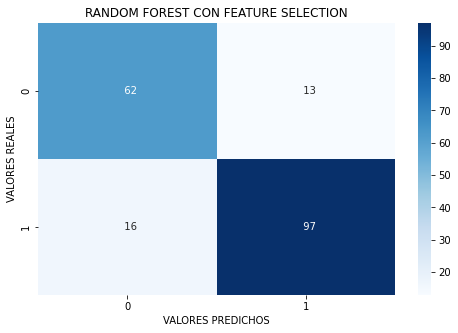

In [34]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, pipe_rf_feature_selection.predict(X_test)), annot=True, fmt='4d',cmap='Blues')
plt.xlabel('VALORES PREDICHOS')
plt.ylabel('VALORES REALES')
plt.title('RANDOM FOREST CON FEATURE SELECTION')
plt.show()

#### FEATURE IMPORTANCE RANDOM FOREST CON FEATURE SELECTION

In [35]:
best_features_names=pd.Series(X_train.loc[:,pipe_rf_feature_selection[0].support_].columns)
feature_importance_best_features = pd.Series(best_rf_feature_selector.feature_importances_)

In [36]:
feature_importance_best_rf_feature_selector_df = pd.concat([best_features_names, feature_importance_best_features], axis = 1)

feature_importance_best_rf_feature_selector_df.columns = ["features", "feature importances"]

feature_importance_best_rf_feature_selector_df = feature_importance_best_rf_feature_selector_df.sort_values(by = "feature importances", ascending= False)
feature_importance_best_rf_feature_selector_df

,features,feature importances
8,speechiness,0.228259
0,acousticness,0.149365
7,loudness,0.142687
3,energy,0.109920
1,danceability,0.081054
6,liveness,0.062146
9,tempo,0.056510
2,duration,0.051213
10,valence,0.050908
4,instrumentalness,0.038288


Observamos que RFECV nos reduce la dimensionalidad de 13 a 11 regresores.

## PUESTA EN PRODUCCION

Ahora vamos a utilizar un dataset de canciones, descargado de la pagina de Kaggle, para estimar que canciones podrian gustarle a esta persona.

https://www.kaggle.com/datasets/yasserh/song-popularity-dataset

In [37]:
# Entrenamos el modelo con todos nuestro datos

best_rf_feature_selector.fit(data.drop("label", axis = 1), data.label)

RandomForestClassifier(n_estimators=500, random_state=1203)

In [38]:
kaggle_df = pd.read_csv("song_data.csv")
data_new = kaggle_df.copy()

data_new = data_new.rename(columns = {'song_duration_ms':'duration',
                                      'audio_mode':'mode',
                                      'audio_valence':'valence'
                                      })
data_new.head(3)

,song_name,song_popularity,duration,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Boulevard of Broken Dreams,73,262333,0.00552,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.01030,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.00817,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324


In [39]:
X_test_new = data_new.drop(['song_popularity', 'song_name'], axis = 1)
#reordenamos las columnas de la data nueva
X_test_new = X_test_new[data.drop('label', axis = 1).columns.values]

In [40]:
def discretizame (row) : 
    """Discretiza en cuatro categorias que tan probable es que la recomendacion sea mas confiable segun su probabilidad 

    Args:
        row (float): probabilidad de que esa cancion le guste al usuario

    Returns:
        string: discretizacion del nivel de recomendacion de la cancion evaluada, segun los gustos del usuario
    """
    if row > 0.9 and row <= 1:
        return "HIGHLY RECOMMENDED"
    if row > 0.7 and row <= 0.9:
        return "muy recomendable"
    if row > 0.6 and row <= 0.7:
        return "recomendable"
    if row > 0.4 and row <= 0.6:
        return "puede gustarle o no"
    else:
        return "no es recomendable"
        

predict_proba_df = pd.DataFrame(best_rf_feature_selector.predict_proba(X_test_new))

predict_proba_df["NIVEL DE RECOMENDACION"] = predict_proba_df[1].apply(lambda x: discretizame(x))

In [41]:
recomendacion_discretizada = pd.concat([kaggle_df["song_name"], predict_proba_df["NIVEL DE RECOMENDACION"]], axis = 1)

recomendacion_discretizada.sample(5)

,song_name,NIVEL DE RECOMENDACION
15580,Don't Tell 'Em - DaaHype Remix,no es recomendable
18534,Rock,puede gustarle o no
10365,La Gota Fría,puede gustarle o no
15437,Bayen Habeit,puede gustarle o no
5250,Goin' Steady,muy recomendable


### LAS MAS RECOMENDADAS

In [42]:
highly = recomendacion_discretizada.loc[recomendacion_discretizada["NIVEL DE RECOMENDACION"] == "HIGHLY RECOMMENDED", "song_name"]
highly.sample(5)

5809                 Bohemia
15278     Drunk Text Romance
1764              Chandelier
18757    Love Brought Weight
9479             Cough Syrup
Name: song_name, dtype: object